# Pipeline for analyzing flow cytometry data

In [1]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import os
import sys

path = '/Users/andrewng/Documents/AHN_FlowTools/'
if not path in sys.path:
    sys.path.insert(1, path)
del path

from AHN_FlowTools import *

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
datadir = list()

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180405_LOCKRkey_coex/yAHN893Pl1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180405_LOCKRkey_coex/Plate2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180405_LOCKRkey_coex/Plate3/')

date = '20180405'

allfiles = {}
strains = ['Plate1','Plate2','Plate3']

for i in range(len(datadir)):
    files = glob.glob(datadir[i] + '*.fcs')
    allfiles[strains[i]] = files

In [3]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [4]:
plateraw = pd.DataFrame(index = rows, columns = cols)

panelDict = {strain:plateraw for strain in strains}
allplates = pd.Panel(panelDict)

In [5]:
for strain in strains:
    for f in allfiles[strain]:
        c = f[-10:-8]
        r = f[-11]
        call = r + c
        allplates[strain].set_value(r, c, FCMeasurement(ID = call, datafile = f))

In [6]:
def FCdatastats(platesort,normalized=None,rows=None,cols=None,FITCthresh=None,FSCthresh=None):

    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    if normalized is None:
        normalized = True
    if rows is None:
        rows = ['A','B','C','D','E','F','G','H']
    if cols is None:
        cols = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if FITCthresh is None:
        FITCthresh = 100
    if FSCthresh is None:
        FSCthresh = 1000

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty})
    RFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    BFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    CFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})

    for row in rows:
        for col in cols:

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh)

                FCM2 = FCM[FCM['FSC-H'] > FSCthresh]
            except TypeError:
                continue

            try:
                if normalized == True:
                    FITC = FCM2['FITC-H']/FCM2['FSC-H']
                    RFP = FCM2['PE-Texas Red-H']/FCM2['FSC-H']
                    BFP = FCM2['DAPI-H']/FCM2['FSC-H']
                    CFP = FCM2['AmCyan-H']/FCM2['FSC-H']

                elif normalized == False:
                    FITC = FCM2['FITC-H']
                    RFP = FCM2['PE-Texas Red-H']
                    BFP = FCM2['DAPI-H']
                    CFP = FCM2['AmCyan-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.sd.loc[row,col])

                RFPstats.raw.set_value(row, col, RFP)
                RFPstats.med.set_value(row,col,RFP.median(axis=0))
                RFPstats.avg.set_value(row,col,RFP.mean(axis=0))
                RFPstats.sd.set_value(row,col,RFP.std(axis=0))
                RFPstats.cv.set_value(row,col,RFPstats.avg.loc[row,col]/RFPstats.sd.loc[row,col])

                BFPstats.raw.set_value(row, col, BFP)
                BFPstats.med.set_value(row,col,BFP.median(axis=0))
                BFPstats.avg.set_value(row,col,BFP.mean(axis=0))
                BFPstats.sd.set_value(row,col,BFP.std(axis=0))
                BFPstats.cv.set_value(row,col,BFPstats.avg.loc[row,col]/BFPstats.sd.loc[row,col])
                
                CFPstats.raw.set_value(row, col, CFP)
                CFPstats.med.set_value(row,col,CFP.median(axis=0))
                CFPstats.avg.set_value(row,col,CFP.mean(axis=0))
                CFPstats.sd.set_value(row,col,CFP.std(axis=0))
                CFPstats.cv.set_value(row,col,CFPstats.avg.loc[row,col]/CFPstats.sd.loc[row,col])
                
            except (AttributeError, TypeError):
                continue

    return [FITCstats, RFPstats, BFPstats, CFPstats]

In [7]:
FITCnorm = {}
RFPnorm = {}
BFPnorm = {}
CFPnorm = {}

for strain in strains: 
    [FITCnorm[strain], RFPnorm[strain],BFPnorm[strain],CFPnorm[strain]] = FCdatastats(allplates[strain],1,rows,cols,100,1000)

In [8]:
#Define the rows

Econcind = range(8)
Pconcind = range(12)

Econc = list()
Pconc = list()

for j in range(7):
    Econc.append('{0:.2f}'.format(round(50*0.5**j,2)))

for i in range(11):
    Pconc.append('{0:.2f}'.format(round(100*0.5**i,2)))

Px = [round(100*0.5**i,2) for i in range(11)]

Econc.append(0)
Pconc.append(0)
Px.append(0)

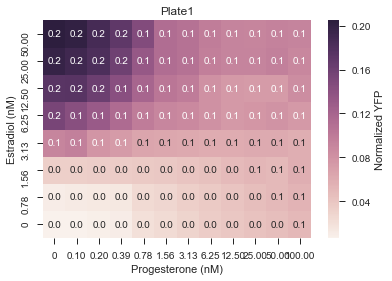

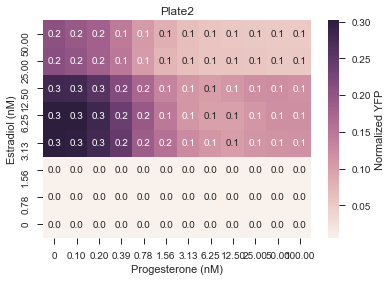

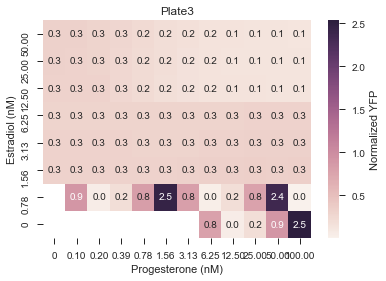

In [9]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

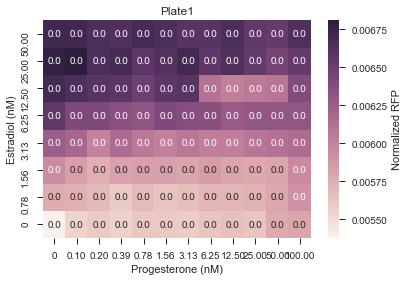

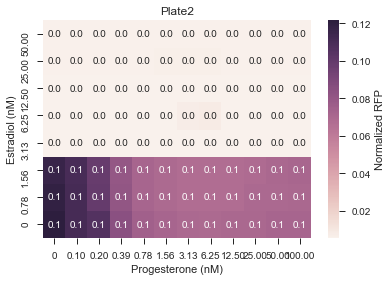

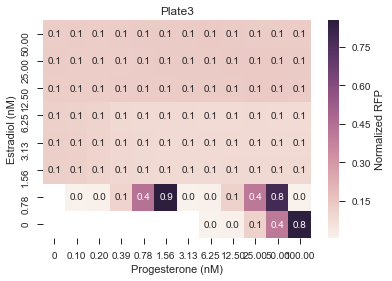

In [10]:
for plate in strains:
    sns.heatmap(RFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized RFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'RFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

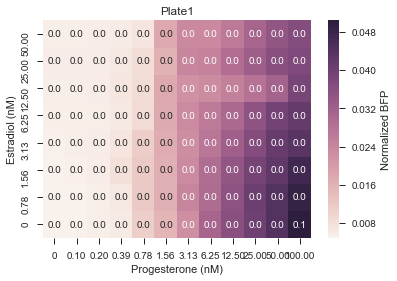

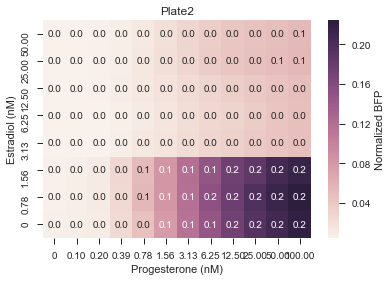

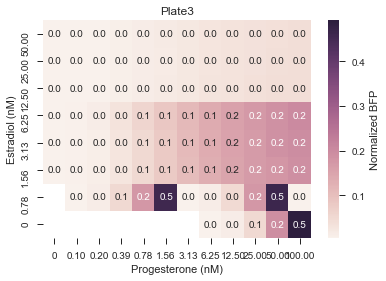

In [11]:
for plate in strains:
    sns.heatmap(BFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized BFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'BFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

## Work up histograms of the data in a 96 well plate format

In [16]:
FITCclean = pd.DataFrame(index = rows, columns = cols)
logFITCclean = pd.DataFrame(index = rows, columns = cols)

for row in rows:
    for col in cols:
        try:
            FITCclean.loc[row,col] = cleandata(allplates['767t1'].loc[row,col].data['FITC-A'].values,100)
            logFITCclean.loc[row,col] = np.log10(cleandata(allplates['767t1'].loc[row,col].data['FITC-A'].values,100))
        except:
            continue

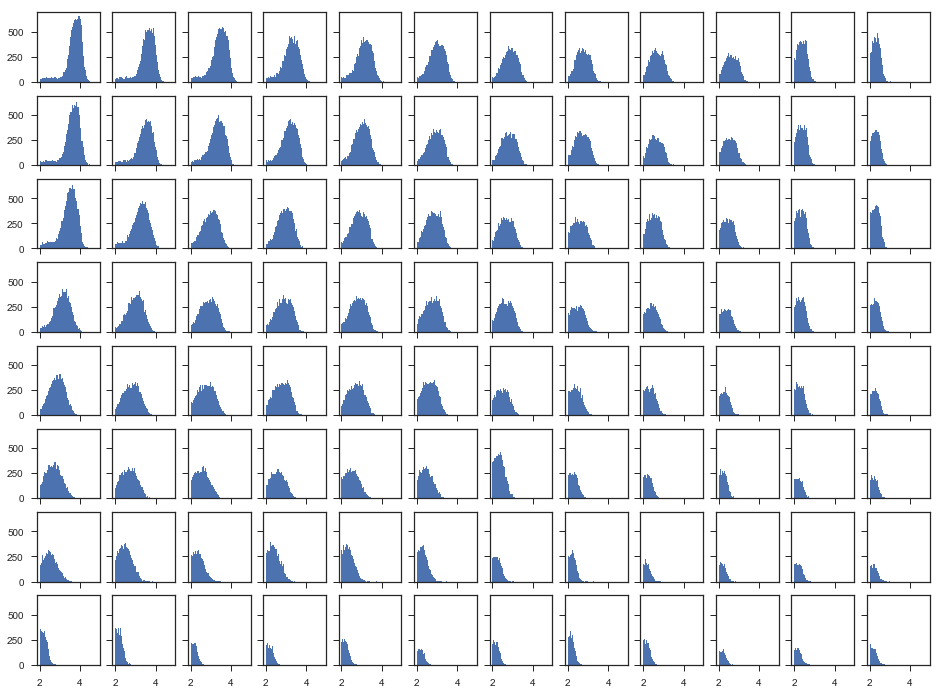

In [17]:
FITC_bincenter = pd.DataFrame(index = rows, columns = cols)
FITC_histy = pd.DataFrame(index = rows, columns = cols)

fig, ax = plt.subplots(8, 12,sharex = True, sharey = True, figsize=(16,12))

for i in range(8):
    for j in range(12):
        try:
            FITC_histy.iloc[i,j],FITC_bincenter.iloc[i,j] = ax[i,j].hist(logFITCclean.iloc[i,j][~np.isnan(logFITCclean.iloc[i,j])],50,normed=0)
        except:
            continue

dest = date + 'fullhist'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

# Process data into array and calculate mean and sd

In [9]:
Aonly = pd.DataFrame(index=['YFP','BFP'], columns=cols)
Aonly_std = pd.DataFrame(index=['YFP','BFP'], columns=cols)

Conly = pd.DataFrame(index=['RFP','BFP'], columns=cols)
Conly_std = pd.DataFrame(index=['RFP','BFP'], columns=cols)

AC_A = pd.DataFrame(index=['YFP','RFP','BFP'], columns=cols)
AC_A_std = pd.DataFrame(index=['YFP','RFP','BFP'], columns=cols)

AC_C = pd.DataFrame(index=['YFP','RFP','BFP'], columns=cols)
AC_C_std = pd.DataFrame(index=['YFP','RFP','BFP'], columns=cols)


for c in cols:
    Aonly.set_value('YFP',c,np.mean([FITCnorm['Plate2'].avg.loc['C',c],FITCnorm['Plate2'].avg.loc['D',c],FITCnorm['Plate2'].avg.loc['E',c]]))
    Aonly_std.set_value('YFP',c,np.std([FITCnorm['Plate2'].avg.loc['C',c],FITCnorm['Plate2'].avg.loc['D',c],FITCnorm['Plate2'].avg.loc['E',c]]))

    Aonly.set_value('BFP',c,np.mean([BFPnorm['Plate2'].avg.loc['C',c],BFPnorm['Plate2'].avg.loc['D',c],BFPnorm['Plate2'].avg.loc['E',c]]))
    Aonly_std.set_value('BFP',c,np.std([BFPnorm['Plate2'].avg.loc['C',c],BFPnorm['Plate2'].avg.loc['D',c],BFPnorm['Plate2'].avg.loc['E',c]]))
    
    Conly.set_value('RFP',c,np.mean([RFPnorm['Plate2'].avg.loc['F',c],RFPnorm['Plate2'].avg.loc['G',c],RFPnorm['Plate2'].avg.loc['H',c]]))
    Conly_std.set_value('RFP',c,np.std([RFPnorm['Plate2'].avg.loc['F',c],RFPnorm['Plate2'].avg.loc['G',c],RFPnorm['Plate2'].avg.loc['H',c]]))
    
    Conly.set_value('BFP',c,np.mean([BFPnorm['Plate2'].avg.loc['F',c],BFPnorm['Plate2'].avg.loc['G',c],BFPnorm['Plate2'].avg.loc['H',c]]))
    Conly_std.set_value('BFP',c,np.std([BFPnorm['Plate2'].avg.loc['F',c],BFPnorm['Plate2'].avg.loc['G',c],BFPnorm['Plate2'].avg.loc['H',c]]))
  
    AC_A.set_value('YFP',c,np.mean([FITCnorm['Plate3'].avg.loc['A',c],FITCnorm['Plate3'].avg.loc['B',c],FITCnorm['Plate3'].avg.loc['C',c]]))
    AC_A_std.set_value('YFP',c,np.std([FITCnorm['Plate3'].avg.loc['A',c],FITCnorm['Plate3'].avg.loc['B',c],FITCnorm['Plate3'].avg.loc['C',c]]))

    AC_A.set_value('RFP',c,np.mean([RFPnorm['Plate3'].avg.loc['A',c],RFPnorm['Plate3'].avg.loc['B',c],RFPnorm['Plate3'].avg.loc['C',c]]))
    AC_A_std.set_value('RFP',c,np.std([RFPnorm['Plate3'].avg.loc['A',c],RFPnorm['Plate3'].avg.loc['B',c],RFPnorm['Plate3'].avg.loc['C',c]]))
    
    AC_A.set_value('BFP',c,np.mean([BFPnorm['Plate3'].avg.loc['A',c],BFPnorm['Plate3'].avg.loc['B',c],BFPnorm['Plate3'].avg.loc['C',c]]))
    AC_A_std.set_value('BFP',c,np.std([BFPnorm['Plate3'].avg.loc['A',c],BFPnorm['Plate3'].avg.loc['B',c],BFPnorm['Plate3'].avg.loc['C',c]]))
    
    AC_C.set_value('YFP',c,np.mean([FITCnorm['Plate3'].avg.loc['D',c],FITCnorm['Plate3'].avg.loc['E',c],FITCnorm['Plate3'].avg.loc['F',c]]))
    AC_C_std.set_value('YFP',c,np.std([FITCnorm['Plate3'].avg.loc['D',c],FITCnorm['Plate3'].avg.loc['E',c],FITCnorm['Plate3'].avg.loc['F',c]]))

    AC_C.set_value('RFP',c,np.mean([RFPnorm['Plate3'].avg.loc['D',c],RFPnorm['Plate3'].avg.loc['E',c],RFPnorm['Plate3'].avg.loc['F',c]]))
    AC_C_std.set_value('RFP',c,np.std([RFPnorm['Plate3'].avg.loc['D',c],RFPnorm['Plate3'].avg.loc['E',c],RFPnorm['Plate3'].avg.loc['F',c]]))

    AC_C.set_value('BFP',c,np.mean([BFPnorm['Plate3'].avg.loc['D',c],BFPnorm['Plate3'].avg.loc['E',c],BFPnorm['Plate3'].avg.loc['F',c]]))
    AC_C_std.set_value('BFP',c,np.std([BFPnorm['Plate3'].avg.loc['D',c],BFPnorm['Plate3'].avg.loc['E',c],BFPnorm['Plate3'].avg.loc['F',c]]))

# Plot Data

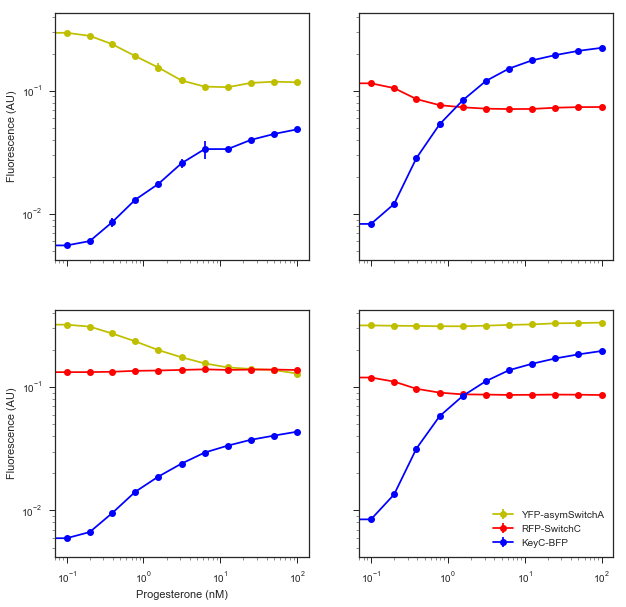

In [27]:
fig, ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))

ax[0,0].errorbar(Px,Aonly.loc['YFP'],yerr=Aonly_std.loc['YFP'],fmt = 'o-', color = 'y',label = 'YFP-asymSwitchA')
ax[0,0].errorbar(Px,Aonly.loc['BFP'],yerr=Aonly_std.loc['BFP'], fmt = 'o-',color = 'b',label = 'KeyA-BFP')

ax[0,1].errorbar(Px,Conly.loc['RFP'],yerr=Conly_std.loc['RFP'],fmt = 'o-', color = 'r', label = 'RFP-SwitchC')
ax[0,1].errorbar(Px,Conly.loc['BFP'],yerr=Conly_std.loc['BFP'],fmt = 'o-', color = 'b',label = 'KeyC-BFP')

ax[1,0].errorbar(Px,AC_A.loc['YFP'],yerr=AC_A_std.loc['YFP'],fmt = 'o-',color= 'y',label = 'YFP-asymSwitchA')
ax[1,0].errorbar(Px,AC_A.loc['RFP'],yerr=AC_A_std.loc['RFP'],fmt = 'o-',color= 'r',label = 'RFP-SwitchC')
ax[1,0].errorbar(Px,AC_A.loc['BFP'],yerr=AC_A_std.loc['BFP'],fmt = 'o-',color = 'b',label = 'KeyA-BFP')

ax[1,1].errorbar(Px,AC_C.loc['YFP'],yerr=AC_C_std.loc['YFP'],fmt = 'o-',color= 'y',label = 'YFP-asymSwitchA')
ax[1,1].errorbar(Px,AC_C.loc['RFP'],yerr=AC_C_std.loc['RFP'],fmt = 'o-',color= 'r',label = 'RFP-SwitchC')
ax[1,1].errorbar(Px,AC_C.loc['BFP'],yerr=AC_C_std.loc['BFP'],fmt = 'o-',color = 'b',label = 'KeyC-BFP')

ax[0,0].set_ylabel('Fluorescence (AU)')
ax[1,0].set_ylabel('Fluorescence (AU)')
ax[0,0].set_yscale('log')

ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('Progesterone (nM)')
#ax1.set_xticks(Pconcind)
#ax2.set_yscale('log',basey=2)

plt.legend()

plt.margins(0.1)
plt.tight_layout()

dest = date + 'CoexpressYRClogxy'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

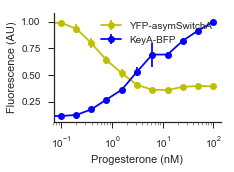

In [10]:
fig, ax1 = plt.subplots(figsize=(3,2))

ax1.errorbar(Px,Aonly.loc['YFP']/Aonly.loc['YFP','12'],yerr=Aonly_std.loc['YFP']/Aonly.loc['YFP','12'],fmt = 'o-', color = 'y',label = 'YFP-asymSwitchA')
ax1.errorbar(Px,Aonly.loc['BFP']/Aonly.loc['BFP','01'],yerr=Aonly_std.loc['BFP']/Aonly.loc['BFP','01'], fmt = 'o-',color = 'b',label = 'KeyA-BFP')

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'AonlyYB'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

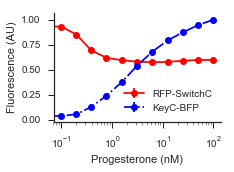

In [11]:
fig, ax1 = plt.subplots(figsize=(3,2))

ax1.errorbar(Px,Conly.loc['RFP']/Conly.loc['RFP','12'],yerr=Conly_std.loc['RFP']/Conly.loc['RFP','12'],fmt = 'o-', color = 'r', label = 'RFP-SwitchC')
ax1.errorbar(Px,Conly.loc['BFP']/Conly.loc['BFP','01'],yerr=Conly_std.loc['BFP']/Conly.loc['BFP','01'],fmt = 'o-.', color = 'b',label = 'KeyC-BFP')

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'ConlyRB'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

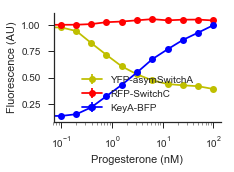

In [12]:
fig, ax1 = plt.subplots(figsize=(3,2))

ax1.errorbar(Px,AC_A.loc['YFP']/AC_A.loc['YFP','12'],yerr=AC_A_std.loc['YFP']/AC_A.loc['YFP','12'],fmt = 'o-',color= 'y',label = 'YFP-asymSwitchA')
ax1.errorbar(Px,AC_A.loc['RFP']/AC_A.loc['RFP','12'],yerr=AC_A_std.loc['RFP']/AC_A.loc['RFP','12'],fmt = 'o-',color= 'r',label = 'RFP-SwitchC')
ax1.errorbar(Px,AC_A.loc['BFP']/AC_A.loc['BFP','01'],yerr=AC_A_std.loc['BFP']/AC_A.loc['BFP','01'],fmt = 'o-',color = 'b',label = 'KeyA-BFP')

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'AC_A_YRB'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

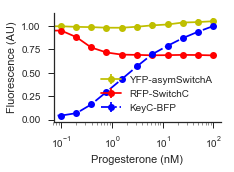

In [13]:
fig, ax1 = plt.subplots(figsize=(3,2))

ax1.errorbar(Px,AC_C.loc['YFP']/AC_C.loc['YFP','12'],yerr=AC_C_std.loc['YFP']/AC_C.loc['YFP','12'],fmt = 'o-',color= 'y',label = 'YFP-asymSwitchA')
ax1.errorbar(Px,AC_C.loc['RFP']/AC_C.loc['RFP','12'],yerr=AC_C_std.loc['RFP']/AC_C.loc['RFP','12'],fmt = 'o-',color= 'r',label = 'RFP-SwitchC')
ax1.errorbar(Px,AC_C.loc['BFP']/AC_C.loc['BFP','01'],yerr=AC_C_std.loc['BFP']/AC_C.loc['BFP','01'],fmt = 'o-.',color = 'b',label = 'KeyC-BFP')

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'AC_C_YRB'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

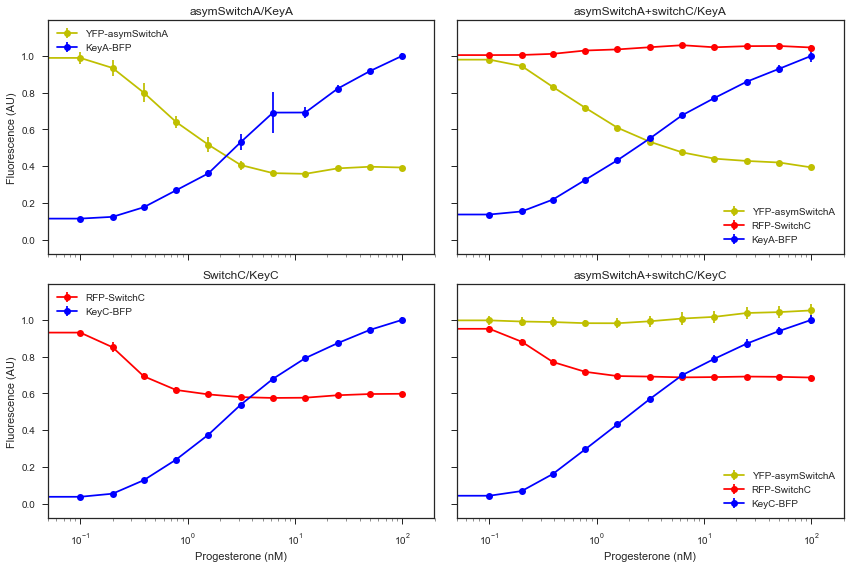

In [69]:
fig, ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(12,8))

ax[0,0].errorbar(Px,Aonly.loc['YFP']/Aonly.loc['YFP','12'],yerr=Aonly_std.loc['YFP']/Aonly.loc['YFP','12'],fmt = 'o-', color = 'y',label = 'YFP-asymSwitchA')
ax[0,0].errorbar(Px,Aonly.loc['BFP']/Aonly.loc['BFP','01'],yerr=Aonly_std.loc['BFP']/Aonly.loc['BFP','01'], fmt = 'o-',color = 'b',label = 'KeyA-BFP')

ax[1,0].errorbar(Px,Conly.loc['RFP']/Conly.loc['RFP','12'],yerr=Conly_std.loc['RFP']/Conly.loc['RFP','12'],fmt = 'o-', color = 'r', label = 'RFP-SwitchC')
ax[1,0].errorbar(Px,Conly.loc['BFP']/Conly.loc['BFP','01'],yerr=Conly_std.loc['BFP']/Conly.loc['BFP','01'],fmt = 'o-', color = 'b',label = 'KeyC-BFP')

ax[0,1].errorbar(Px,AC_A.loc['YFP']/AC_A.loc['YFP','12'],yerr=AC_A_std.loc['YFP']/AC_A.loc['YFP','12'],fmt = 'o-',color= 'y',label = 'YFP-asymSwitchA')
ax[0,1].errorbar(Px,AC_A.loc['RFP']/AC_A.loc['RFP','12'],yerr=AC_A_std.loc['RFP']/AC_A.loc['RFP','12'],fmt = 'o-',color= 'r',label = 'RFP-SwitchC')
ax[0,1].errorbar(Px,AC_A.loc['BFP']/AC_A.loc['BFP','01'],yerr=AC_A_std.loc['BFP']/AC_A.loc['BFP','01'],fmt = 'o-',color = 'b',label = 'KeyA-BFP')

ax[1,1].errorbar(Px,AC_C.loc['YFP']/AC_C.loc['YFP','12'],yerr=AC_C_std.loc['YFP']/AC_C.loc['YFP','12'],fmt = 'o-',color= 'y',label = 'YFP-asymSwitchA')
ax[1,1].errorbar(Px,AC_C.loc['RFP']/AC_C.loc['RFP','12'],yerr=AC_C_std.loc['RFP']/AC_C.loc['RFP','12'],fmt = 'o-',color= 'r',label = 'RFP-SwitchC')
ax[1,1].errorbar(Px,AC_C.loc['BFP']/AC_C.loc['BFP','01'],yerr=AC_C_std.loc['BFP']/AC_C.loc['BFP','01'],fmt = 'o-',color = 'b',label = 'KeyC-BFP')

ax[0,0].set_ylabel('Fluorescence (AU)')
ax[1,0].set_ylabel('Fluorescence (AU)')
#ax[0,0].set_yscale('log')

ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('Progesterone (nM)')
ax[1,1].set_xlabel('Progesterone (nM)')
#ax1.set_xticks(Pconcind)
#ax2.set_yscale('log',basey=2)

ax[0,0].legend()
ax[0,0].set_title('asymSwitchA/KeyA')

ax[0,1].legend()
ax[0,1].set_title('asymSwitchA+switchC/KeyA')

ax[1,0].legend()
ax[1,0].set_title('SwitchC/KeyC')

ax[1,1].legend()
ax[1,1].set_title('asymSwitchA+switchC/KeyC')


plt.margins(0.1)
plt.tight_layout()

dest = date + 'NormCoexpressYRClogxy'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()